In [1]:
%matplotlib inline
import itertools
import numpy as np
import numpy.random as rnd
import time
import gpflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter
plt.style.use('ggplot')

In [35]:
import sys
sys.path.append('../code')
from dgp import DGP

gpflow.config.set_default_summary_fmt('notebook')
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
file1 = open('x1.txt','rt')
x1 = np.array([line.split(',') for line in file1.readlines()], np.float64)
file2 = open('x2.txt','rt')
x2 = np.array([line.split(',') for line in file2.readlines()], np.float64)
file3 = open('value.txt','rt')
z = np.array([line.split(',') for line in file3.readlines()], np.float64)

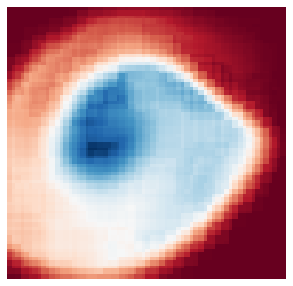

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
from matplotlib import cm
p = ax.pcolor(x1, x2, z, cmap=cm.RdBu)

plt.axis('off')
plt.show()
fig.savefig('original.png',dpi=300)

In [29]:
x_train = np.concatenate([x1.reshape(-1,1),x2.reshape(-1,1)], axis=1)
y_train = z.reshape(-1,)

In [30]:
x_train.shape

(10000, 2)

In [89]:
y_train = np.reshape(y_train,(-1,))

In [90]:
minibatch_size = 1000
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(10000)

In [125]:
from scipy.cluster.vq import kmeans2
Z = kmeans2(x_train, 100, minit='points')[0]
D = x_train.shape[1]

In [36]:
likelihood = gpflow.likelihoods.Gaussian(variance=300.) 

dims = [2,2,2,1]

kernels = []
for l in range(3):
    kernels.append(gpflow.kernels.SquaredExponential(variance=2., lengthscale=2.) + gpflow.kernels.White(variance=2e-6))
    
model = DGP(x_train, y_train, Z, dims, kernels, likelihood,
                white=True, num_samples=1, num_data=x_train.shape[0], minibatch_size=1000)

# start inner layers deterministically
for layer in model.layers[:-1]:
    layer.q_sqrt = Parameter(layer.q_sqrt.value() * 1e-5, 
                             transform=triangular())

In [162]:
likelihood = gpflow.likelihoods.Gaussian() 
kernel = gpflow.kernels.SquaredExponential(variance=2., lengthscale=[1.,1.]) + gpflow.kernels.White()
m = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood,
    inducing_variable=Z, whiten=True, q_diag=True)

In [161]:
gpflow.utilities.print_summary(m, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,True,(),float64,4.729420404005942
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,True,"(2,)",float64,[4.6170553 0.64696445]
SVGP.kernel.kernels[1].variance,Parameter,Softplus,True,(),float64,0.4984320643670045
SVGP.likelihood.variance,Parameter,Softplus,True,(),float64,199.7658945402646
SVGP.inducing_variable.Z,Parameter,,True,"(100, 2)",float64,"[[0.47483118, 1.80426804..."
SVGP.q_mu,Parameter,,True,"(100, 1)",float64,[[0.98124737...
SVGP.q_sqrt,Parameter,Softplus,True,"(100, 1)",float64,[[0.34536518...


In [163]:
gpflow.utilities.print_summary(m, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,True,(),float64,2.0
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,True,"(2,)",float64,[1. 1.]
SVGP.kernel.kernels[1].variance,Parameter,Softplus,True,(),float64,1.0
SVGP.likelihood.variance,Parameter,Softplus,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,True,"(100, 2)",float64,"[[3.25311956e-01, 3.42444050e-03..."
SVGP.q_mu,Parameter,,True,"(100, 1)",float64,[[0....
SVGP.q_sqrt,Parameter,Softplus,True,"(100, 1)",float64,[[1....


In [131]:
gpflow.utilities.print_summary(model, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
DGP.likelihood.likelihood.variance,Parameter,Softplus,True,(),float64,313.48707432078567
DGP.layers[0].q_mu,Parameter,,True,"(50, 2)",float64,"[[-4.94776765e-01, 2.35887676e-01..."
DGP.layers[0].q_sqrt,Parameter,FillTriangular,True,"(2, 50, 50)",float64,"[[[-0.00316421, 0., 0...."
DGP.layers[0].inducing_points.Z,Parameter,,True,"(50, 2)",float64,"[[-0.10482395, 0.02079803..."
DGP.layers[0].kernel.kernels[0].variance,Parameter,Softplus,True,(),float64,2.430163964661486
DGP.layers[0].kernel.kernels[0].lengthscale,Parameter,Softplus,True,(),float64,0.41414875828197956
DGP.layers[0].kernel.kernels[1].variance,Parameter,Softplus,True,(),float64,1.2625016678942685e-07
DGP.layers[1].q_mu,Parameter,,True,"(50, 2)",float64,"[[-1.13114911e+00, 9.40724115e-01..."
DGP.layers[1].q_sqrt,Parameter,FillTriangular,True,"(2, 50, 50)",float64,"[[[-0.0019902, 0., 0...."
DGP.layers[1].inducing_points.Z,Parameter,,True,"(50, 2)",float64,"[[0.18709915, -0.31336286..."


In [164]:
from tqdm import tqdm_notebook as tqdm

In [165]:
@tf.function(autograph=False)
def optimization_step(optimizer, model:gpflow.models.SVGP, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.elbo(*batch)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

@tf.function(autograph=False)
def optimization_step_dgp(optimizer, model, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.elbo(*batch, full_cov=False)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, iterations):
    logf = []
    adam = tf.optimizers.Adam(0.01)
    
    train_it = iter(train_ds.batch(minibatch_size))
    for step in range(iterations):
        neg_elbo = optimization_step(adam, model, next(train_it))
        elbo = - neg_elbo
        if step % 10 == 0:
            logf.append(elbo.numpy())
        if step % 1000 == 0:
            print(elbo.numpy())
    return logf

def run_adam_dgp(model, iterations):
    logf = []
    adam = tf.optimizers.Adam(0.01)
    train_it = iter(train_ds.batch(minibatch_size))
    for step in tqdm(range(iterations)):
        neg_elbo = optimization_step_dgp(adam, model, next(train_it))
        elbo = - neg_elbo
        if step % 10 == 0:
            logf.append(elbo.numpy())
        if step % 1000 == 0:
            print(elbo.numpy())
    return logf

-1309169877.2979896
-141717553.53158185
-89902130.00605376
-68651760.31174567
-56830052.41623247
-47034229.20507817
-39242199.190498054
-32947960.630193427
-29358194.4834917
-24542170.855861757


Text(0.5, 1.0, 'ELBO of SVGP')

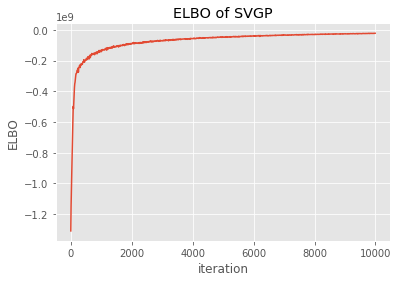

In [166]:
maxiter = ci_niter(10000)
logf = run_adam(m, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.title('ELBO of SVGP')

/homes/rx220/env/lib/python3.7/site-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


-258684896.26250777
-1078314.255519274
-422354.2074666832
-259456.66794114624
-216019.40167693474
-139206.8510312605
-124034.82812395325
-81171.71356968745
-79888.04178993583
-73981.90267263558



Text(0.5, 1.0, 'ELBO of DGP3')

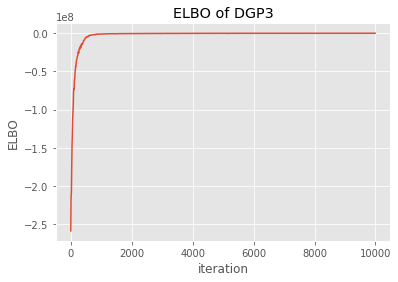

In [48]:
maxiter = ci_niter(10000)
logf_dgp = run_adam_dgp(model, maxiter)
plt.plot(np.arange(maxiter)[::10], logf_dgp)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.title('ELBO of DGP3')

In [57]:
p = np.linspace(-1.2,0.6, 500)
v = np.linspace(-0.07, 0.07, 500)
p1,v1 = np.meshgrid(p,v)
x_test = np.concatenate([p1.reshape(-1,1),v1.reshape(-1,1)], axis=1)


In [58]:
x_test.shape

(250000, 2)

In [76]:

def batch_assess(model, X):
    n_batches = max(int(X.shape[0]/1000.), 1)
    y = []
    f11 = []
    f12 = []
    f21 = []
    f22 = []
    for X_batch in np.array_split(X, n_batches):
        predict_y = predict_output(model, X_batch)
        predict_f11, predict_f12, predict_f21, predict_f22 = predict_inner(model, X_batch)
        y.append(predict_y)
        f11.append(predict_f11)
        f12.append(predict_f12)
        f21.append(predict_f21)
        f22.append(predict_f22)
        
    y = np.concatenate(y, 0)
    f11 = np.concatenate(f11, 0)
    f12 = np.concatenate(f12, 0)
    f21 = np.concatenate(f21, 0)
    f22 = np.concatenate(f22, 0)
    return y,f11,f12,f21,f22

S = 100
def predict_output(model, X_batch):
    m, v = model.predict_y(X_batch, S)
    mean = np.average(m, 0)
    return mean

def predict_inner(model, X_batch):
    f, m, v = model.predict_all_layers(X_batch, S)
    m1 = np.average(m[0],0)
    f11 = m1[:,0]
    f12 = m1[:,1]
    m2 = np.average(m[1],0)
    f21 = m2[:,0]
    f22 = m2[:,1]
    return f11,f12,f21,f22

In [108]:
def batch_assess_sgp(model, assess_model, X):
    n_batches = max(int(X.shape[0]/1000.), 1)
    y_sgp = []
    for X_batch in np.array_split(X, n_batches):
        m = assess_model(model, X_batch)
        y_sgp.append(m)
    y_sgp = np.concatenate(y_sgp, 0)
    return y_sgp

def assess_single_layer(model, X_batch):
    m, v = model.predict_y(X_batch)
    return m

In [167]:
y_sgp = batch_assess_sgp(m, assess_single_layer, x_test)

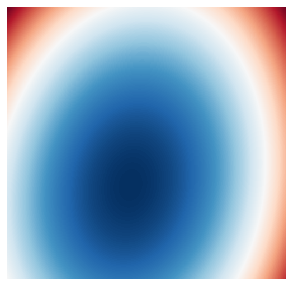

In [198]:
Z_sgp = y_sgp.reshape((500,500))
from matplotlib import cm
fig, ax = plt.subplots(figsize=(5, 5))
p = ax.pcolor(p1, v1, Z_sgp, cmap=cm.RdBu)

plt.axis('off')
plt.show()
fig.savefig('sgpcar.png',dpi=300)

In [77]:
y,f11,f12,f21,f22 = batch_assess(model, x_test)

In [170]:
f11.min()

-2.492283628735267

In [171]:
fx1 = np.linspace(f11.min(),f11.max(),500)
fx2 = np.linspace(f12.min(),f12.max(),500)
fx11,fx22 = np.meshgrid(fx1,fx2)
x_layer1 = np.concatenate([fx11.reshape(-1,1),fx22.reshape(-1,1)], axis=1)

In [181]:
fa1 = np.linspace(output1.min(),output1.max(),500)
fa2 = np.linspace(output2.min(),output2.max(),500)
fa11,fa22 = np.meshgrid(fa1,fa2)
x_layer2 = np.concatenate([fa11.reshape(-1,1),fa22.reshape(-1,1)], axis=1)

In [185]:
def predict_output_layer(layer, X, S=100):
    sX = tf.tile(tf.expand_dims(X, 0), [S, 1, 1]) # [S,N,D]
    F = sX
    zs = None
    f, m, v = layer.sample_from_conditional(sX, z=zs)
    mean = np.average(m, 0)
    return mean

def batch_assess_layer(layer, assess_model, X):
    n_batches = max(int(X.shape[0]/1000.), 1)
    output1 = []
    output2 = []
    for X_batch in np.array_split(X, n_batches):
        m = assess_model(layer, X_batch)
        output1.append(m[:,0])
        output2.append(m[:,1])
    output1 = np.concatenate(output1, 0)
    output2 = np.concatenate(output2, 0)
    return output1, output2

def batch_assess_final_layer(layer, assess_model, X):
    n_batches = max(int(X.shape[0]/1000.), 1)
    output = []
    for X_batch in np.array_split(X, n_batches):
        m = assess_model(layer, X_batch)
        output.append(m)
    output = np.concatenate(output, 0)
    return output

In [173]:
output1, output2 = batch_assess_layer(model.layers[1], predict_output_layer, x_layer1)

In [187]:
output = batch_assess_final_layer(model.layers[2], predict_output_layer, x_layer2)

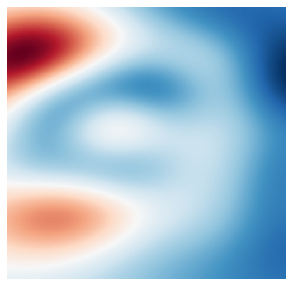

In [195]:
output1 = output1.reshape((500,500))
putput2 = output2.reshape((500,500))
fig, ax = plt.subplots(figsize=(5, 5))
p = ax.pcolor(fx11, fx22, output1, cmap=cm.RdBu)

plt.axis('off')
plt.show()
fig.savefig('layer21.png',dpi=300)

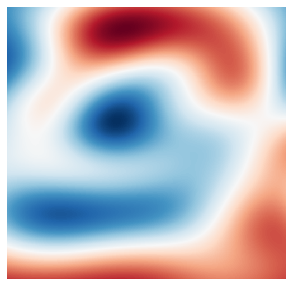

In [196]:
fig, ax = plt.subplots(figsize=(5, 5))
p = ax.pcolor(fx11, fx22, putput2, cmap=cm.RdBu)

plt.axis('off')
plt.show()
fig.savefig('layer22.png',dpi=300)

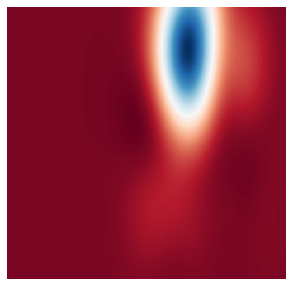

In [197]:
output = output.reshape((500,500))
fig, ax = plt.subplots(figsize=(5, 5))
p = ax.pcolor(fa11, fa22, output, cmap=cm.RdBu)

plt.axis('off')
plt.show()
fig.savefig('layerout.png',dpi=300)

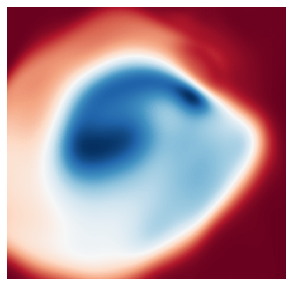

In [192]:
Z = y.reshape((500,500))
from matplotlib import cm
fig, ax = plt.subplots(figsize=(5, 5))
p = ax.pcolor(p1, v1, Z, cmap=cm.RdBu)
plt.axis('off')
plt.show()
fig.savefig('dgp3car.png',dpi=300)

In [78]:
f11 = f11.reshape((500,500))
f12 = f12.reshape((500,500))
f21 = f21.reshape((500,500))
f22 = f22.reshape((500,500))

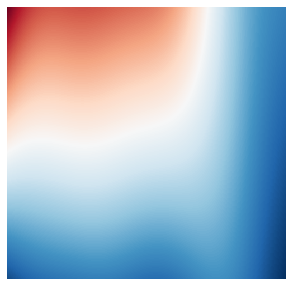

In [193]:
fig, ax = plt.subplots(figsize=(5, 5))
p = ax.pcolor(p1, v1, f11, cmap=cm.RdBu)
plt.axis('off')
plt.show()
fig.savefig('layer11.png',dpi=300)

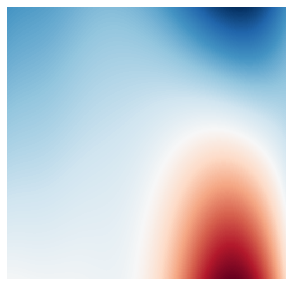

In [194]:
fig, ax = plt.subplots(figsize=(5, 5))
p = ax.pcolor(p1, v1, f12, cmap=cm.RdBu)
plt.axis('off')
plt.show()
fig.savefig('layer12.png',dpi=300)